<a href="https://colab.research.google.com/github/taxuyou/library-recommend-and-timeseries-predict/blob/master/visitor_%EC%98%88%EC%B8%A1_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [0]:
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

In [0]:
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
 
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [0]:
# 하이퍼파라미터
input_data_column_cnt = 4  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 1           # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 12   # 각 셀의 (hidden)출력 크기
forget_bias = 1          # 망각편향(기본값 1.0)
num_stacked_layers = 4     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 2000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

In [5]:
# 데이터를 로딩한다.
file_name = 'test.csv' # 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['days','holiday','workingday','visitors']
raw_dataframe = pd.read_csv(file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
 
#raw_dataframe.drop('date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 4 columns):
days          840 non-null object
holiday       840 non-null object
workingday    840 non-null object
visitors      840 non-null object
dtypes: object(4)
memory usage: 26.3+ KB


In [6]:
data_info = raw_dataframe.values[1:].astype(np.float) #  문자열을 부동소수점형으로 변환한다
print("data_info.shape: ", data_info.shape)
print("data_info[0]: ", data_info[0])

data_info.shape:  (839, 4)
data_info[0]:  [7.000e+00 1.000e+00 0.000e+00 2.221e+03]


In [7]:
data_info

array([[7.000e+00, 1.000e+00, 0.000e+00, 2.221e+03],
       [1.000e+00, 0.000e+00, 1.000e+00, 2.447e+03],
       [2.000e+00, 0.000e+00, 1.000e+00, 2.963e+03],
       ...,
       [6.000e+00, 1.000e+00, 0.000e+00, 3.647e+03],
       [7.000e+00, 1.000e+00, 0.000e+00, 3.909e+03],
       [1.000e+00, 0.000e+00, 1.000e+00, 2.564e+03]])

In [9]:
# 데이터들을 정규화한다
# ['days','holiday','workingday','visitors']에서 'workingday'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
day = data_info[:,:3]
norm_day = min_max_scaling(day) # 가격형태 데이터 정규화 처리
print("day.shape: ", day.shape)
print("day[0]: ", day[0])
print("norm_day[0]: ", norm_day[0])
print("="*100) # 화면상 구분용

day.shape:  (839, 3)
day[0]:  [7. 1. 0.]
norm_day[0]:  [0.99999999 0.14285714 0.        ]


In [10]:
# 방문자 데이터를 정규화한다
# ['days','holiday','workingday','visitors']에서 마지막 'visitors'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
visitor = data_info[:,-1:]
norm_visitor = min_max_scaling(visitor) # 거래량형태 데이터 정규화 처리
print("visitor.shape: ", visitor.shape)
print("vitisor[0]: ", visitor[0])
print("norm_visitor[0]: ", norm_visitor[0])
print("="*100) # 화면상 구분용
 
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_day, norm_visitor), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [3]] # 타켓은 방문자다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값
 
 
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 방문자수(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

visitor.shape:  (839, 1)
vitisor[0]:  [2221.]
norm_visitor[0]:  [0.27098079]
x.shape:  (839, 4)
x[0]:  [0.99999999 0.14285714 0.         0.27098079]
x[-1]:  [0.14285714 0.         0.14285714 0.32052578]
y[0]:  [0.27098079]
y[-1]:  [0.32052578]
[[0.99999999 0.14285714 0.         0.27098079]] -> [0.3036256]


In [0]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.97)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [12]:
test_size

26

In [13]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)
 
# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 1, 4), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [14]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [15]:
# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)
 
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
 
 
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))
 
 
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 1, 12), dtype=float32)


In [16]:
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 2 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 2, train_error(A): 0.2924589514732361, test_error(B): 0.30617982149124146, B-A: 0.013720870018005371
epoch: 4, train_error(A): 0.25153034925460815, test_error(B): 0.26340967416763306, B-A: 0.011879324913024902
epoch: 6, train_error(A): 0.209596186876297, test_error(B): 0.21851445734500885, B-A: 0.008918270468711853
epoch: 8, train_error(A): 0.1697748601436615, test_error(B): 0.17355257272720337, B-A: 0.00377771258354187
epoch: 10, train_error(A): 0.1401933878660202, test_error(B): 0.1349807232618332, B-A: -0.005212664604187012
epoch: 12, train_error(A): 0.13433705270290375, test_error(B): 0.1175268366932869, B-A: -0.016810216009616852
epoch: 14, train_error(A): 0.1495383083820343, test_error(B): 0.12619397044181824, B-A: -0.023344337940216064
epoch: 16, train_error(A): 0.15864859521389008, test_error(B): 0.13390636444091797, B-A: -0.024742230772972107
epoch: 18, train_error(A): 0.15510348975658417, test_error(B): 0.13084518909454346, B-A: -0.02425830066204071
epoch:

In [17]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

input_data_column_cnt: 4,output_data_column_cnt: 1,seq_length: 1,rnn_cell_hidden_dim: 12,forget_bias: 1,num_stacked_layers: 4,keep_prob: 1.0,epoch_num: 2000,learning_rate: 0.01,train_error: 0.05276897,test_error: 0.07368013,min_test_error: 0.06856402


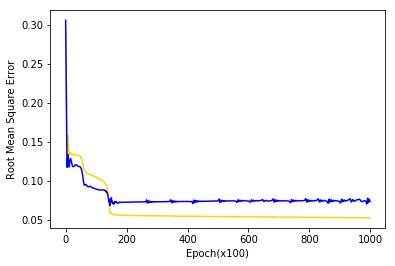

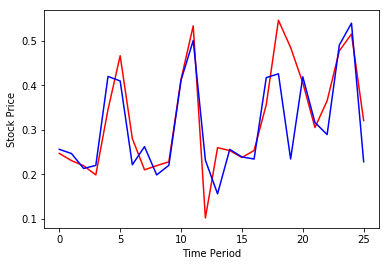

In [18]:
# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')
 
plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

In [0]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
error1 = mean_absolute_percentage_error(testY, test_predict)
print("MAPE :",error1,"%")

MAPE : 17.425428379605385 %


In [21]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 방문자를 예측
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(visitor, test_predict) # 금액데이터 역정규화한다
print("ATS", test_predict[0]) # 예측한 visitor를 출력한다

recent_data.shape: (1, 1, 4)
recent_data: [[[0.14285714 0.         0.14285714 0.32052578]]]
test_predict [0.30027232]
ATS [2423.7852]


In [0]:

# def test_network(model_dir, batch_size, test_x, test_y):
#     inputs_, labels_, keep_prob_ = model_inputs()
#     embed = build_embedding_layer(inputs_, vocab_size, embed_size)
#     initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, embed, keep_prob_, batch_size)
#     predictions, loss, optimizer = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate)
#     accuracy = build_accuracy(predictions, labels_)

#     saver = tf.train.Saver()

#     test_acc = []
#     with tf.Session() as sess:
#         saver.restore(sess, tf.train.latest_checkpoint(model_dir))
#         test_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
#         for ii, (x, y) in enumerate(utl.get_batches(test_x, test_y, batch_size), 1):
#             feed = {inputs_: x,
#  labels_: y[:, None],
#  keep_prob_: 1,
#  initial_state: test_state}
#             batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
#             test_acc.append(batch_acc)
#         print("Test Accuracy: {:.3f}".format(np.mean(test_acc)))


# with tf.Graph().as_default():
#     test_network('checkpoints', 
#                  batch_size, test_x, test_y)